# NIR Spectral Analysis with AS7263 
A clean, step-by-step notebook to:
1. Load & visualize spectral data
2. Preprocess inputs & encode outputs
3. Build & visualize Conv1D → MLP multi-output model
4. Train & plot learning curves
5. Evaluate & save final model

**Dataset include:**
610nm	680nm	730nm	760nm	810nm	860nm	fruit	brix	ripeness	moisture	grade	defect	fungus

**Input include:**
- 6-dimensional Vector NIR Spectral: [610nm, 680nm, 730nm, 760nm, 810nm, 860nm]
- fruit type( apple, mango, strawberry)
- ripeness

**Outputs include:**
- °Brix (regression)
- Moisture content (regression)
- Grade (A/B/C classification)
- Internal defect (Y/N)
- Disease or fungal infection (Y/N)

In [1]:
!pip install -q tensorflow
!pip install scikit-learn
!pip install seaborn

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D, Dropout, BatchNormalization, Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
import datetime
from tensorflow.keras.layers import (
    Input, Conv1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization, Concatenate, Add, Activation, 
    Embedding, Multiply
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
import tf2onnx





[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Load Dataset & Initial Visualization

In [2]:
# Đường dẫn file CSV của bạn
csv_path = "data_nir/NIR_fruit_dataset_final_v10.csv"  # 🔁 thay nếu cần

# Đọc dữ liệu
df = pd.read_csv(csv_path)

# Hiển thị bảng dữ liệu
print("📊 Dữ liệu từ file CSV:")
df.head(200)  # Hiển thị 20 dòng đầu tiên
df.corr(numeric_only=True)


📊 Dữ liệu từ file CSV:


,610nm,680nm,730nm,760nm,810nm,860nm,brix,ripeness,moisture,defect,fungus
610nm,1.000000,-0.033475,0.113729,-0.019070,0.081977,0.052936,0.012136,0.000344,-0.006644,-0.011454,-0.010942
680nm,-0.033475,1.000000,-0.038157,0.034651,0.023718,0.085338,-0.027854,-0.009720,0.008116,0.014437,0.015223
730nm,0.113729,-0.038157,1.000000,0.144801,0.036959,-0.061838,0.536134,0.145490,-0.293500,-0.068444,-0.199397
760nm,-0.019070,0.034651,0.144801,1.000000,-0.090465,-0.016259,0.263615,0.059709,-0.106307,-0.062715,-0.119207
810nm,0.081977,0.023718,0.036959,-0.090465,1.000000,0.343916,-0.116628,0.005392,0.409810,-0.399146,-0.313822
860nm,0.052936,0.085338,-0.061838,-0.016259,0.343916,1.000000,-0.302500,-0.011690,0.596547,-0.456488,-0.360595
brix,0.012136,-0.027854,0.536134,0.263615,-0.116628,-0.302500,1.000000,0.242653,-0.709930,-0.028779,-0.153985
ripeness,0.000344,-0.009720,0.145490,0.059709,0.005392,-0.011690,0.242653,1.000000,-0.138334,-0.090103,-0.091179
moisture,-0.006644,0.008116,-0.293500,-0.106307,0.409810,0.596547,-0.709930,-0.138334,1.000000,-0.383501,-0.494354
defect,-0.011454,0.014437,-0.068444,-0.062715,-0.399146,-0.456488,-0.028779,-0.090103,-0.383501,1.000000,0.242551


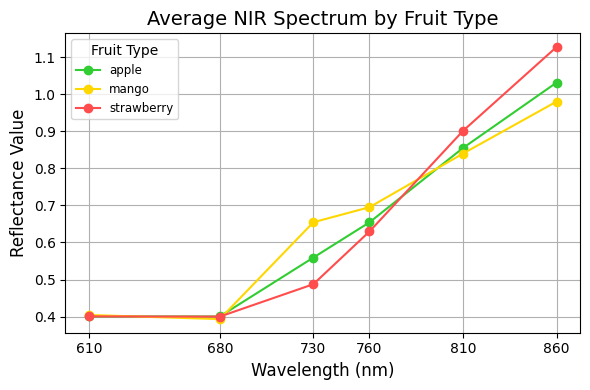

<Figure size 640x480 with 0 Axes>

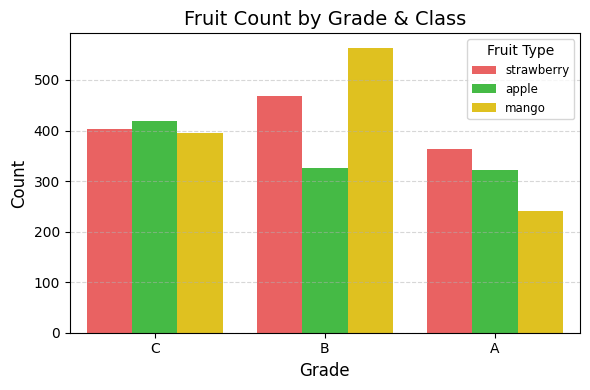

<Figure size 640x480 with 0 Axes>

In [3]:
# Các cột phổ
wavelengths = ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm']
wavelength_vals = [610, 680, 730, 760, 810, 860]

# Tính trung bình cường độ tại mỗi bước sóng
mean_vals = df[wavelengths].mean()

# Tính trung bình phổ theo loại trái cây
avg_spectra = df.groupby('fruit')[wavelengths].mean()

custom_palette = {
    'apple': '#32CD32',    
    'mango': '#FFD700',   
    'strawberry': '#FF4C4C'     
}

# Vẽ biểu đồ đường phổ trung bình theo từng loại trái cây
plt.figure(figsize=(6, 4))
for fruit, row in avg_spectra.iterrows():
    plt.plot(wavelength_vals, row.values, label=fruit, marker='o', color=custom_palette.get(fruit,'gray'))

plt.title("Average NIR Spectrum by Fruit Type", fontsize=14)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Reflectance Value", fontsize=12)
plt.xticks(wavelength_vals)
plt.grid(True)
plt.legend(title="Fruit Type", fontsize=8.5, title_fontsize=10)
plt.tight_layout()
plt.show()

plt.savefig('data_nir/avg_spectrum_by_fruit.png', dpi=300)
plt.show()


# Vẽ biểu đồ đếm số lượng theo fruit và grade
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='grade', hue='fruit', palette=custom_palette)

plt.title("Fruit Count by Grade & Class", fontsize=14)
plt.xlabel("Grade", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Fruit Type", fontsize=8.5, title_fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.savefig('data_nir/fruit_count_by_grade.png', dpi=300)
plt.show()


## 2. Preprocessing

In [4]:
# 1. Cột phổ NIR
wavelengths = ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm']

# 2. One-hot encode cột 'fruit'
df = pd.get_dummies(df, columns=['fruit'])  # → tạo fruit_apple, fruit_mango, fruit_strawberry
fruit_features = [col for col in df.columns if col.startswith("fruit_")]
X_ripeness = df[['ripeness']].values  # shape (num_samples, 1)
# 3. Tạo input vector: phổ + ripeness + fruit (theo thứ tự logic cho CNN)
input_features = wavelengths + ['ripeness'] + fruit_features  # Tổng cộng: 10 đặc trưng
X_raw = df[input_features].values

# 4. Output regression: Chỉ còn Brix và Moisture
y_reg = df[['brix', 'moisture']].values  

# 5. Output classification
y_cat = df[['grade', 'defect', 'fungus']].copy()

# One-hot encode grade (multi-class)
enc = OneHotEncoder(sparse_output=False)
y_grade = enc.fit_transform(y_cat[['grade']])

# Convert defect & fungus thành nhị phân
y_defect = y_cat['defect'].astype(int).values
y_fungus = y_cat['fungus'].astype(int).values

from sklearn.preprocessing import StandardScaler
import joblib

# 4. Chuẩn hóa đầu vào
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# ✅ Save scaler sau khi fit
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler đã lưu vào scaler.pkl")

# 7. Reshape cho Conv1D: (samples, 10 đặc trưng, 1 kênh)
X_cnn = X_scaled.reshape(-1, X_scaled.shape[1], 1)

# 8. Chia train-test
X_train, X_test, y_reg_train, y_reg_test, y_grade_train, y_grade_test, y_def_train, y_def_test, y_fun_train, y_fun_test = train_test_split(
    X_cnn, y_reg, y_grade, y_defect, y_fungus, test_size=0.2, random_state=42
)

# 9. Kiểm tra
print("✅ Data shapes:")
print("X_train:", X_train.shape)
print("y_reg_train:", y_reg_train.shape)
print("y_grade_train:", y_grade_train.shape)
print("fruit features:", fruit_features)

✅ Scaler đã lưu vào scaler.pkl
✅ Data shapes:
X_train: (2800, 10, 1)
y_reg_train: (2800, 2)
y_grade_train: (2800, 3)
fruit features: ['fruit_apple', 'fruit_mango', 'fruit_strawberry']


## 3. Build Model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Concatenate, Add, Activation
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Multiply
from tensorflow.keras.layers import Embedding
import tensorflow as tf

inp = Input(shape=(10, 1))  # 10 đặc trưng phổ

#  Positional Embedding (Learned)
pos = tf.range(start=0, limit=10, delta=1)
pos_emb = Embedding(input_dim=10, output_dim=32)(pos)  # (10, 32)

# Expand input to 32 dim
x_proj = Conv1D(32, kernel_size=1, padding='same')(inp)
x = x_proj + pos_emb  # (None, 10, 32)

# 🔹 Conv Branch 1 (kernel=2 + residual)
x1 = Conv1D(32, kernel_size=2, padding='same', activation='relu')(x)
x1 = Conv1D(32, kernel_size=2, padding='same')(x1)
x1 = Add()([x, x1])  # Residual
x1 = Activation('relu')(x1)

# 🔹 Conv Branch 2 (kernel=5 + residual)
x2 = Conv1D(32, kernel_size=5, padding='same', activation='relu')(x)
x2 = Conv1D(32, kernel_size=5, padding='same')(x2)
x2 = Add()([x, x2])  # Residual
x2 = Activation('relu')(x2)

# 🔗 Merge branches
x = Concatenate()([x1, x2])  # (None, 10, 64)
x = BatchNormalization()(x)

# 🔍 Multi-Head Attention block 1
attn1 = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = Add()([x, attn1])  # Residual
x = LayerNormalization()(x)

# 🔍 Multi-Head Attention block 2 (stacked)
attn2 = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = Add()([x, attn2])  # Residual
x = LayerNormalization()(x)

# 🧠 Attention-weighted pooling
att_weights = Dense(1, activation='softmax')(x)  # (None, 10, 1)
x = Multiply()([x, att_weights])
x = GlobalAveragePooling1D()(x)  # (None, 64)

# Thay Shared MLP
shared = Dense(128, activation='relu')(x)
shared = LayerNormalization()(shared)
shared = Dropout(0.1)(shared)

shared = Dense(64, activation='relu')(shared)
shared = LayerNormalization()(shared)
shared = Dropout(0.1)(shared)

# 📌 Task-specific branches
# 🔺 Regression branch
x_reg = Dense(32, activation='relu')(shared)
x_reg = Dropout(0.1)(x_reg)
reg_out = Dense(2, name='regression')(x_reg)  # brix, moisture

# 🔺 Classification branch
x_cls = Dense(32, activation='relu')(shared)
x_cls = Dropout(0.1)(x_cls)

# Cross-feature fusion
x_cls_fused = Concatenate()([x_cls, x_reg])

# 🎯 Outputs
grade_out = Dense(3, activation='softmax', name='grade')(x_cls_fused)
def_out = Dense(1, activation='sigmoid', name='defect')(x_cls_fused)
fun_out = Dense(1, activation='sigmoid', name='fungus')(x_cls_fused)

# 📦 Build model
model = Model(inputs=inp, outputs=[reg_out, grade_out, def_out, fun_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 32)    │         64 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 32)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 32)    │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 32)    │      5,152 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 32)    │      2,080 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 32)    │      5,152 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10, 32)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 10, 32)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 64)    │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 64)    │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     16,640 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_4[0][0]     

 Total params: 69,896 (273.03 KB)

 Trainable params: 69,768 (272.53 KB)

 Non-trainable params: 128 (512.00 B)

## 4. Compile Model

In [6]:
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K

# ✅ Focal Loss custom (binary & categorical)
def focal_loss_binary(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow((1 - p_t), gamma)
        return K.mean(-alpha_factor * modulating_factor * K.log(p_t))
    return loss

def focal_loss_categorical(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        modulating_factor = K.pow(1 - y_pred, gamma)
        loss = alpha * modulating_factor * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return loss


# ⚙️ Compile
# Khởi tạo TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

# Compile model với loss weights
model.compile(
    optimizer='adam',
    loss={
        'regression': Huber(),  # Huber ổn định hơn MSE với outlier
        'grade': focal_loss_categorical(gamma=2., alpha=0.25),
        'defect': focal_loss_binary(gamma=2., alpha=0.25),
        'fungus': focal_loss_binary(gamma=2., alpha=0.25)
    },
    loss_weights={
        'regression': 1.0,
        'grade': 1.0,
        'defect': 2.0,
        'fungus': 1.0
    },
    metrics={
        'grade': ['accuracy'],
        'defect': ['accuracy'],
        'fungus': ['accuracy']
    }
)


## 5. Train & Plot Learning Curves

Epoch 1/100


c:\Users\ADMIN\Desktop\Intel 2025 AI\venv\Lib\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - defect_accuracy: 0.7106 - defect_loss: 0.0811 - fungus_accuracy: 0.6122 - fungus_loss: 0.1281 - grade_accuracy: 0.4673 - grade_loss: 0.1789 - loss: 39.0333 - regression_loss: 38.5624 - val_defect_accuracy: 0.6400 - val_defect_loss: 0.0958 - val_fungus_accuracy: 0.6443 - val_fungus_loss: 0.0621 - val_grade_accuracy: 0.4557 - val_grade_loss: 0.0934 - val_loss: 18.9735 - val_regression_loss: 18.6211
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - defect_accuracy: 0.6810 - defect_loss: 0.1975 - fungus_accuracy: 0.6564 - fungus_loss: 0.2344 - grade_accuracy: 0.4119 - grade_loss: 0.3389 - loss: 12.5696 - regression_loss: 11.6010 - val_defect_accuracy: 0.6414 - val_defect_loss: 0.1913 - val_fungus_accuracy: 0.6457 - val_fungus_loss: 0.2206 - val_grade_accuracy: 0.6514 - val_grade_loss: 0.0709 - val_loss: 3.7177 - val_regression_loss: 3.0526
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - defect_accuracy: 0.7657 - defect_loss: 0.1448 - fun

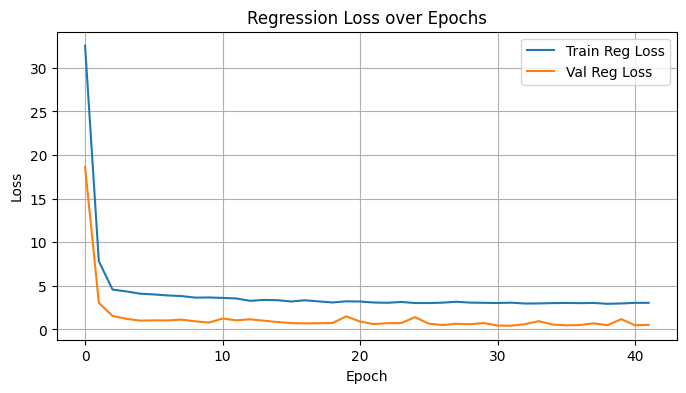

c:\Users\ADMIN\Desktop\Intel 2025 AI\venv\Lib\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
🔹 Regression Outputs (°Brix, Moisture):
  ▪️ MSE:  1.3708
  ▪️ MAE:  0.7545

🔹 Classification - Grade:
              precision    recall  f1-score   support

           A       0.87      0.97      0.92       187
           B       0.96      0.89      0.92       265
           C       1.00      0.98      0.99       248

    accuracy                           0.94       700
   macro avg       0.94      0.95      0.94       700
weighted avg       0.95      0.94      0.94       700


🔹 Classification - Internal Defect:
              precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00       449
      Defect       1.00      1.00      1.00       251

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700


🔹 Classification - Fungus Infection:
              precision    recall  f1-score   support

   No Fungus       

In [7]:
def evaluate_model(model, X_test, y_reg_test, y_grade_test, y_def_test, y_fun_test, enc):
    # 🚀 Dự đoán
    pred_reg, pred_grade, pred_def, pred_fun = model.predict(X_test)

    # 🎯 HỒI QUY (Brix, Moisture)
    print("🔹 Regression Outputs (°Brix, Moisture):")
    mse = mean_squared_error(y_reg_test, pred_reg)
    mae = mean_absolute_error(y_reg_test, pred_reg)
    print(f"  ▪️ MSE:  {mse:.4f}")
    print(f"  ▪️ MAE:  {mae:.4f}")
    print()

    # 🏷️ PHÂN LOẠI GRADE (A/B/C)
    print("🔹 Classification - Grade:")
    y_true_grade = np.argmax(y_grade_test, axis=1)
    y_pred_grade = np.argmax(pred_grade, axis=1)
    print(classification_report(y_true_grade, y_pred_grade, target_names=enc.categories_[0]))
    print()

    # ⚠️ PHÂN LOẠI DEFECT
    print("🔹 Classification - Internal Defect:")
    y_pred_def = (pred_def > 0.5).astype(int)
    print(classification_report(y_def_test, y_pred_def, target_names=["No Defect", "Defect"]))
    print()

    # 🍄 PHÂN LOẠI FUNGUS
    print("🔹 Classification - Fungus Infection:")
    y_pred_fun = (pred_fun > 0.5).astype(int)
    print(classification_report(y_fun_test, y_pred_fun, target_names=["No Fungus", "Fungus"]))


# ⏹️ Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    X_train,
    {
        'regression': y_reg_train,
        'grade': y_grade_train,
        'defect': y_def_train,
        'fungus': y_fun_train
    },
    validation_data=(
        X_test,
        {
            'regression': y_reg_test,
            'grade': y_grade_test,
            'defect': y_def_test,
            'fungus': y_fun_test
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# Vẽ loss của nhánh regression
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['regression_loss'], label='Train Reg Loss')
plt.plot(history.history['val_regression_loss'], label='Val Reg Loss')
plt.title('Regression Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


evaluate_model(
    model,
    X_test,
    y_reg_test,
    y_grade_test,
    y_def_test,
    y_fun_test,
    enc  # encoder đã fit trước đó với OneHotEncoder
)

##6 test thủ công số liệu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
🎯 Inference Result for Manual Input
────────────────────────────────────────────
📌 Predicted Brix (°Bx):      8.49
📌 Predicted Moisture (%):    79.35

🏷️ Grade Prediction:          C → Confidence: 60.51%
⚠️ Internal Defect:           Yes → Confidence: 95.04%
🍄 Fungus Infection:          Yes → Confidence: 50.05%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


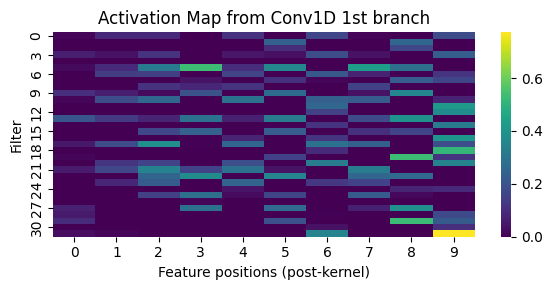

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


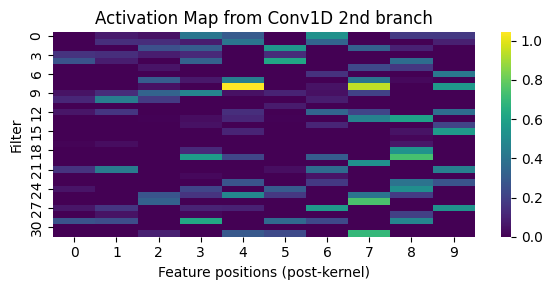

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


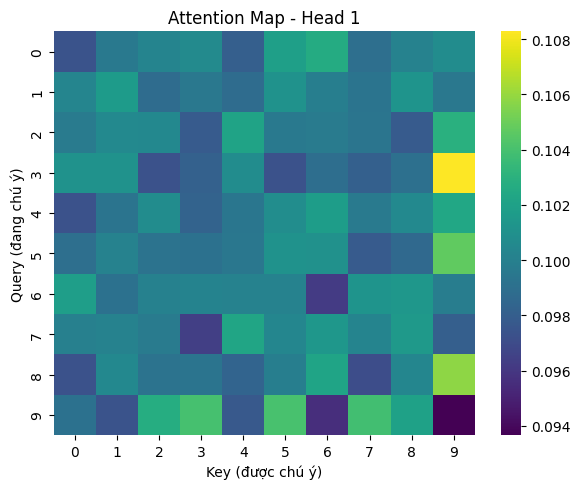

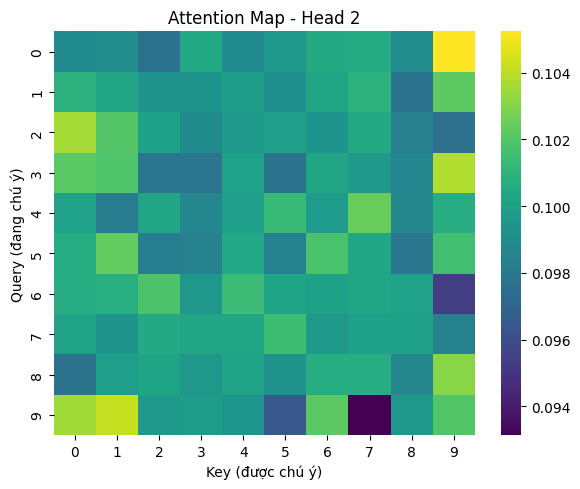

c:\Users\ADMIN\Desktop\Intel 2025 AI\venv\Lib\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


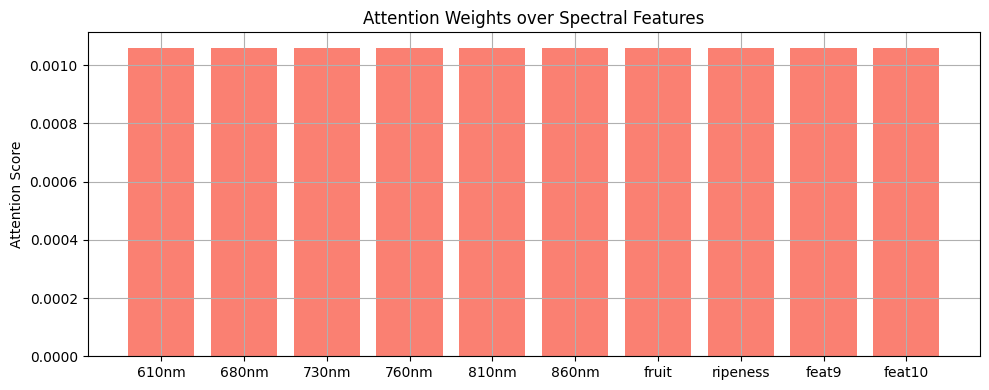

In [8]:

# 📥 Nhập thủ công theo thứ tự:
# [610nm, 680nm, 730nm] + [ripeness] + [760nm, 810nm, 860nm] + [fruit_apple=0, fruit_mango=0, fruit_strawberry=1]
manual_input = np.array([[ 
    0.3945146939587981
,    # 610nm
    0.3959648698591893

,    # 680nm
    0.49325196501093834


,     # 730nm
    0.5438129337936717




,    # 760nm
    0.8651213672824536


,    # 810nm
    0.8973568011848727

,    # 860nm
    9,            # ripeness (giá trị từ CV hoặc cảm biến ngoài)
    0,              # fruit_apple
    0,              # fruit_mango
    1               # fruit_strawberry
]])

# ✅ Scale dữ liệu đầu vào
manual_input_scaled = scaler.transform(manual_input)

# ✅ Reshape phù hợp với input (samples, 10, 1)
manual_input_scaled = manual_input_scaled.reshape((1, 10, 1))

# 🚀 Dự đoán từ mô hình
pred_reg, pred_grade, pred_defect, pred_fungus = model.predict(manual_input_scaled)

# 🧾 In kết quả rõ ràng
grade_map = {0: 'A', 1: 'B', 2: 'C'}

print("🎯 Inference Result for Manual Input")
print("────────────────────────────────────────────")
print(f"📌 Predicted Brix (°Bx):      {pred_reg[0][0]:.2f}")
print(f"📌 Predicted Moisture (%):    {pred_reg[0][1]:.2f}")
print()
print(f"🏷️ Grade Prediction:          {grade_map[np.argmax(pred_grade[0])]} → Confidence: {np.max(pred_grade[0]):.2%}")
print(f"⚠️ Internal Defect:           {'Yes' if pred_defect[0][0] > 0.5 else 'No'} → Confidence: {pred_defect[0][0]:.2%}")
print(f"🍄 Fungus Infection:          {'Yes' if pred_fungus[0][0] > 0.5 else 'No'} → Confidence: {pred_fungus[0][0]:.2%}")





# ⚙️ Trích layer Conv1D nhánh 1 thứ nhất
conv_layer2 = [layer for layer in model.layers if isinstance(layer, Conv1D)][1]
feature_extractor2 = Model(inputs=model.input, outputs=conv_layer2.output)

# 🧪 Predict với layer này
features2 = feature_extractor2.predict(manual_input_scaled)

# 📊 Vẽ heatmap layer Conv1D nhánh 1 thứ nhất
plt.figure(figsize=(6, 3))
sns.heatmap(features2[0].T, cmap='viridis', xticklabels=range(features2.shape[1]))
plt.title("Activation Map from Conv1D 1st branch")
plt.xlabel("Feature positions (post-kernel)")
plt.ylabel("Filter")
plt.tight_layout()
plt.show()

# ⚙️ Trích layer Conv1D thứ nhất nhánh hai
conv_layer3 = [layer for layer in model.layers if isinstance(layer, Conv1D)][2]
feature_extractor3 = Model(inputs=model.input, outputs=conv_layer3.output)

# 🧪 Predict lại với layer thứ hai
features3 = feature_extractor3.predict(manual_input_scaled)

# 📊 Vẽ heatmap layer Conv1D nhánh 2 thứ nhất
plt.figure(figsize=(6, 3))
sns.heatmap(features3[0].T, cmap='viridis', xticklabels=range(features2.shape[1]))
plt.title("Activation Map from Conv1D 2nd branch")
plt.xlabel("Feature positions (post-kernel)")
plt.ylabel("Filter")
plt.tight_layout()
plt.show()


#attention stack
# ⚙️ 1. Trích output sau BatchNormalization (trước attention)
bn_layer = [layer for layer in model.layers if "batch_normalization" in layer.name][0]
bn_model = Model(inputs=model.input, outputs=bn_layer.output)

# 🧪 2. Predict đầu vào attention
x_bn = bn_model.predict(manual_input_scaled)  # Output: (1, 10, 64)

# ⚙️ 3. Tạo lại MultiHeadAttention layer với return_attention_scores=True
inp_attn = Input(shape=(10, 64))
attn_layer = MultiHeadAttention(num_heads=2, key_dim=32)  
attn_out, attn_scores = attn_layer(inp_attn, inp_attn, inp_attn, return_attention_scores=True)

# 📦 4. Tạo model mới để lấy attention scores
attn_model = Model(inputs=inp_attn, outputs=attn_scores)

# 🧪 5. Predict attention scores
attn_scores_val = attn_model.predict(x_bn)  # (1, 2, 10, 10)

# 📊 6. Vẽ attention heatmap từng head
for head in range(attn_scores_val.shape[1]):
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_scores_val[0, head], cmap='viridis', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Attention Map - Head {head+1}")
    plt.xlabel("Key (được chú ý)")
    plt.ylabel("Query (đang chú ý)")
    plt.tight_layout()
    plt.show()


# 📌 Submodel từ input đến attention weights
# Bạn cần sửa model gốc 1 chút: gán att_weights vào biến ngoài (bổ sung tên layer)
# --> tạm giả sử bạn đã lưu layer này tên là `att_weights`

# Tìm layer attention trong mô hình
att_layer = [l for l in model.layers if isinstance(l, Dense) and l.output.shape[-1] == 1][2]


# Xây sub-model từ input đến attention weights
att_model = Model(inputs=model.input, outputs=att_layer.output)

# 📥 Tạo 1 sample đầu vào (ví dụ giả)
# Với đầu vào 10 đặc trưng dạng phổ (spectrum), giả lập một chuỗi 10 giá trị bất kỳ
sample_input = np.random.rand(1, 10, 1).astype(np.float32)  # batch size = 1

# 🎯 Dự đoán attention weights
attention_scores = att_model.predict(sample_input)  # shape (1, 10, 1)
attention_scores = attention_scores.reshape(-1)  # (10,)

# 🖼️ Vẽ biểu đồ attention
plt.figure(figsize=(10, 4))
plt.bar(range(10), attention_scores, color='salmon')
plt.xticks(range(10), ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm', 'fruit', 'ripeness', 'feat9', 'feat10'])
plt.ylabel('Attention Score')
plt.title('Attention Weights over Spectral Features')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Evaluate & Save Model

In [9]:
model.evaluate(X_test, [y_reg_test, y_grade_test, y_def_test, y_fun_test])
model.export("nir_model_v3_savedmodel")
print('Saved as nir_model_v3_savedmodel')



c:\Users\ADMIN\Desktop\Intel 2025 AI\venv\Lib\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - defect_accuracy: 0.9997 - defect_loss: 0.0021 - fungus_accuracy: 0.9739 - fungus_loss: 0.0046 - grade_accuracy: 0.9202 - grade_loss: 0.0118 - loss: 0.4317 - regression_loss: 0.4111     
INFO:tensorflow:Assets written to: nir_model_v3_savedmodel\assets


INFO:tensorflow:Assets written to: nir_model_v3_savedmodel\assets


Saved artifact at 'nir_model_v3_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  1848839146576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848839145808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848839145232: TensorSpec(shape=(10, 32), dtype=tf.float32, name=None)
  1848839145040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848839147728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848839143888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848839145616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848839147536: TensorSpec(shape=(), dtype=tf.resourc